# Классификация изображений с помощью сверточных нейронных сетей (CNN) в Keras

В рамках данного проекта мы обучим нейросеть распознавать рукописные английские буквы.

In [68]:
# Импорт библиотек
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.api.optimizers import Adam
from keras.api.models import load_model
from keras.src.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.src.layers import Dense, Flatten, Conv2D,Dropout, MaxPooling2D,InputLayer

**Использование ```astype('float32') ``` может значительно сократить объем занимаемой памяти.**

Почему это особенно выгодно в нашем случае:

Пиксели обычно находятся в диапазоне от ```0-255 ``` (uint8) или нормализованные ```0-1 ```. ```float32 ``` способен точно представлять эти значения без какой-либо значительной потери данных.

```int64 ``` занимает 8 байт на число, в то время как ```float32 ``` требует всего 4 байта, что означает экономию в 50% памяти.

In [69]:
# Чтение датасета.
df = pd.read_csv('dataset/A_Z_Handwritten_Data.csv')
memory = df.memory_usage(deep=True).sum()
df.info() # Имеет тип int64, который занимает 8 байт на число.
print(f"До преобразования: {memory / 1e9:.1f} GB")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372450 entries, 0 to 372449
Columns: 785 entries, 0 to 0.648
dtypes: int64(785)
memory usage: 2.2 GB
До преобразования: 2.3 GB


Почему мы используем ```float32```, а не ```int32```. Нам требуются высокоточные данные без потери дробной части.

In [70]:
df = df.astype('float32')
memory = df.memory_usage(deep=True).sum()
df.info() # Теперь тип float32, который занимает 4 байт на число.
print(f"После преобразования в float32: {memory / 1e9:.1f} GB")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372450 entries, 0 to 372449
Columns: 785 entries, 0 to 0.648
dtypes: float32(785)
memory usage: 1.1 GB
После преобразования в float32: 1.2 GB


**Что у нас есть?**
- **372 450 строк**
- **785 столбцов, которые представляют пиксели**

In [71]:
df.shape

(372450, 785)

Давайте проверим, нет ли в наборе null значений.

In [100]:
df.isnull().sum()

0        0
0.1      0
0.2      0
0.3      0
0.4      0
        ..
0.644    0
0.645    0
0.646    0
0.647    0
0.648    0
Length: 785, dtype: int64

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372450 entries, 0 to 372449
Columns: 785 entries, 0 to 0.648
dtypes: float32(785)
memory usage: 1.1 GB


Давайте взглянем на эти данные. В первой колонке расположены наши буквенные обозначения: от ```0-A``` до ```25-Z```.

In [73]:
df

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372445,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
372446,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
372447,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
372448,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Удалим нулевую колонку из набора и присвоим ее переменной ```Y``` - это будут наши метки.

In [96]:
# Определим словарь
word_dict = {
    0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X', 24:'Y',25:'Z'
}
x = df.drop('0', axis=1) # Наши пиксели
y = df['0'] # Наши метки


Необходимо преобразовать данные размером 784 в формат изображения с разрешением 28 на 28 пикселей, чтобы мы могли визуализировать наши изображения.

Как мы это сделаем:

```X_train.values``` — преобразуем ```DataFrame``` в ```numpy``` массив.

```X_train.shape[0]``` — указываем количество строк (изображений). Функция ```shape``` возвращает два значения: ```[0]``` — количество строк, ```[1]``` — количество столбцов. Поэтому мы используем ```[0]```, чтобы получить все строки из набора.

```(X_train.shape[0], 28, 28)``` — преобразуем каждую строку (1D-вектор) в изображение с разрешением 28×28 пикселей.

In [75]:
# Делим данные
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
# Изменяем форму
X_train = np.reshape(X_train.values, (X_train.shape[0], 28, 28))
X_test = np.reshape(X_test.values, (X_test.shape[0], 28, 28))
X_train.shape

(297960, 28, 28)

 Глянем на наши изображения.

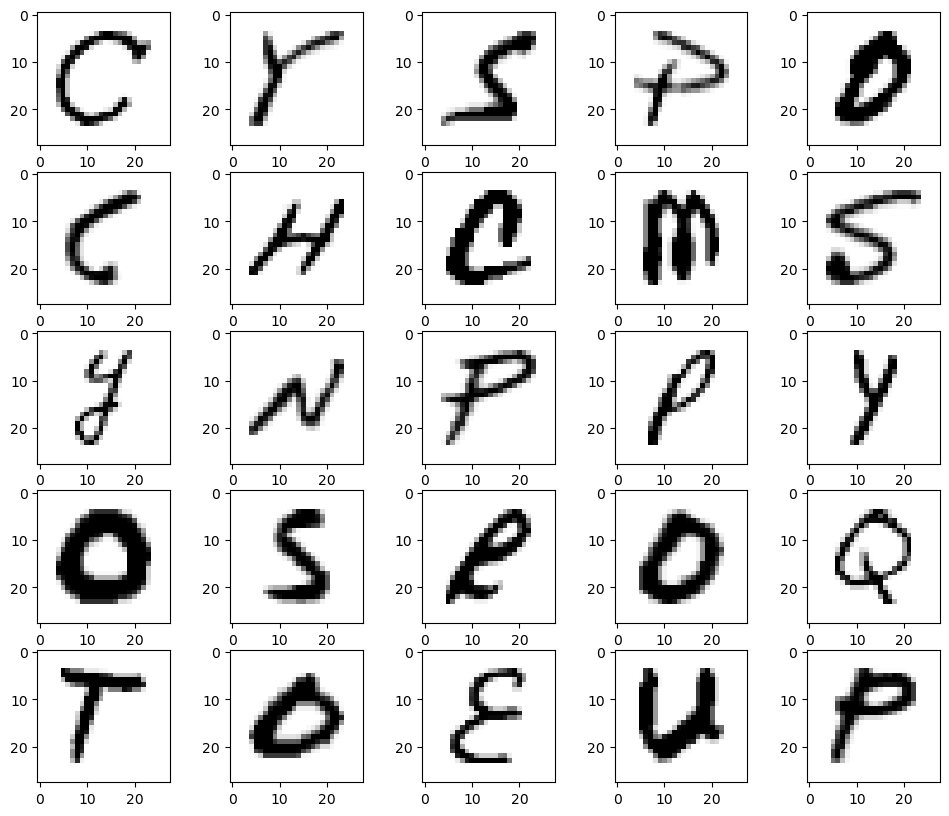

In [76]:
plt.figure(figsize=(12, 10))
#  Задаем количество строк и столбцов
row, columns = 5, 5
for i in range(25):
    # Создаем сетку 5х5
    plt.subplot(columns, row, i + 1)
    # Визуализируем изображение с цветовой гаммой Greys(серые оттенки), 'nearest' - без сглаживания
    plt.imshow(X_train[i].reshape([28, 28]), interpolation='nearest', cmap='Greys')
#  Выводим график на экран
plt.show()

Нормализуем данные, разделив все значения пикселей на 255, чтобы они находились в диапазоне от 0 до 1.

In [77]:
train_images = X_train / 255.0
test_images = X_test / 255.0

Преобразование данных в формат, подходящий для использования в модели нейросети.

Это необходимо для того, чтобы сделать данные совместимыми с моделями нейросетей, которые ожидают изображения в формате ```(batch_size, height, width, channels)```, где ```channels``` представляет собой количество каналов. Например, для черно-белых изображений это будет один канал, а для RGB-изображений — три.

In [78]:
train_images = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2], 1)
test_images = test_images.reshape(test_images.shape[0], test_images.shape[1], test_images.shape[2], 1)

Теперь преобразуем метки классов в формат ```one-hot-encoding```. Этот метод преобразует метки классов в вектор, где все классы равны нулю, за исключением одного, который имеет значение 1.

Например: если метка класса ```0```, то вектор будет выглядеть```[1,0,...,0]```. Т.е ```1``` на позиции ```0``` будет соответствовать букве ```A```.

In [79]:
total_classes = 26
y_train_classes = keras.utils.to_categorical(y_train, total_classes)
y_test_classes = keras.utils.to_categorical(y_test, total_classes)

In [80]:
X_t, X_val, y_t, y_val = train_test_split(train_images, y_train_classes, test_size=0.1, random_state=42)

In [81]:
X_t.shape

(268164, 28, 28, 1)

In [82]:
y_t.shape

(268164, 26)

### Объявляем модель и настраиваем слои.
#### **Слои:**
* InputLayer – слой меняет форму входного изображения: 28×28 пикселей, 1 канал (черно-белое изображение).
* Conv2D - свёрточный слой, который выделяет особенности(features) из изображения
    * **filters** - это число фильтров(ядер свёртки), каждый из которых распознает определенный шаблон. Таким образом, на выходе мы получим количество карт признаков, равное количеству фильтров.
    * **kernel_size** - размер ядра свёртки. Ядро просматривает локальные участки изображения указанного размера.
    * **padding** - если не добавлять ```padding```, то при каждом шаге свертки изображение будет уменьшаться. ```padding``` помогает сохранить его размер. ```padding='valid'``` (без отступов), ```padding='same'``` (с отступами, сохраняет размер)
    * **activation** - активационная функция
* MaxPool2D - слой уменьшает размер карты признаков из слоя Conv2D, выбирая максимум в каждом блоке.
    * **pool_size** - размер окна, который просматривается для уменьшения размера карты признаков.
    * **strides** - шаг перемещения окна. Stride=2 → Фильтр перепрыгивает 1 пиксель.
* Dropout - метод регуляризации, помогает модели избежать переобучения. Отключает часть нейронов(указывается %) на каждому шаге обучения.
* Flatten - слой преобразуется многомерные данные в одномерный вектор, чтобы подать его в полносвязный слой.
* Dense - полносвязный слой, принимает одномерный вектор. Указываем количество нейронов и функцию активации.
* Dense(выходной слой) - последний слой используем для классификации. 26 - количество классов в нашем случае. activation='softmax' — это активационная функция, которая используется для многоклассовой классификации.


In [83]:
model = keras.Sequential()
model.add(InputLayer(shape=(28, 28, 1)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(399, activation='relu'))
model.add(Dense(26, activation='softmax'))

### Далее мы настроим нашу модель.
* compile() - настройка модели.
* Adam - адаптирует скорость обучения для каждого параметра модели, что помогает ускорить обучение и улучшить его стабильность.
* learning_rate - скорость обучения
* loss - функция потерь.
* metrics - отлеживающая метрика.
* EarlyStopping - используется для преждевременной остановки модели, когда она перестает обучаться.
    * monitor - метрика за которой надо следить в нашем случае потери, если не уменьшается остановить процесс.
    * min_delta - минимальное значение метрики, которое будет считаться улучшением или ухудшением. Т.е  больше 0 или меньше 0
    * patience - через сколько эпох модель будет продолжать обучаться, если нет улучшения.
    * verbose - 0 - никогда не выводит информацию о процессе обучения. 1 - выводит информацию о каждой эпохе. 2 - выводит информацию о каждом шаге.
    * mode - как отслеживать улучшение метрики
        * auto: Keras автоматически определит, в каком направлении должна изменяться метрика для того, чтобы считать её улучшением.
        * min: Для метрик, где нужно минимизировать значение (например, val_loss).
        * max: Для метрик, где нужно максимизировать значение (например, accuracy).

In [84]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='auto')

Обучение модели.
* epochs - количество итераций столько модель будет проходить по всем данным
* batch_size - количество примеров, которые будет брать модель за одну итерацию, чтобы вычислить градиент и обновления весов.
* callbacks - список функций, которые будут выполняться в процессе обучения.
* validation_data - данные на которых модель будет обобщаться.

Метод fit() возвращает объект history, который содержать информацию об обучении:
    * history.history — словарь, где ключами будут метрики (например, accuracy, loss), а значениями — списки значений этих метрик для каждой эпохи.

In [85]:
history = model.fit(X_t, y_t, epochs=10, batch_size=250, callbacks=[stop], validation_data=(X_val, y_val))

Epoch 1/10
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 37s 33ms/step - accuracy: 0.8393 - loss: 0.5689 - val_accuracy: 0.9814 - val_loss: 0.0654
Epoch 2/10
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - accuracy: 0.9770 - loss: 0.0797 - val_accuracy: 0.9866 - val_loss: 0.0473
Epoch 3/10
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - accuracy: 0.9836 - loss: 0.0568 - val_accuracy: 0.9878 - val_loss: 0.0419
Epoch 4/10
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - accuracy: 0.9862 - loss: 0.0476 - val_accuracy: 0.9893 - val_loss: 0.0379
Epoch 5/10
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - accuracy: 0.9883 - loss: 0.0395 - val_accuracy: 0.9912 - val_loss: 0.0307
Epoch 6/10
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - accuracy: 0.9899 - loss: 0.0340 - val_accuracy: 0.9914 - val_loss: 0.0294
Epoch 7/10
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - accuracy: 0.9908 - loss: 0.0297 - val_accuracy: 0.9924 - val_loss: 0.0267
Epoch 8/10
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - accuracy: 0.9917 -

In [86]:
# Cохраним модель.
model.save('model_cnn.keras')

In [87]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 399)            │       204,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 26)             │        10,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,279 (3.52 MB)

 Trainable params: 307,759 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 615,520 (2.35 MB)

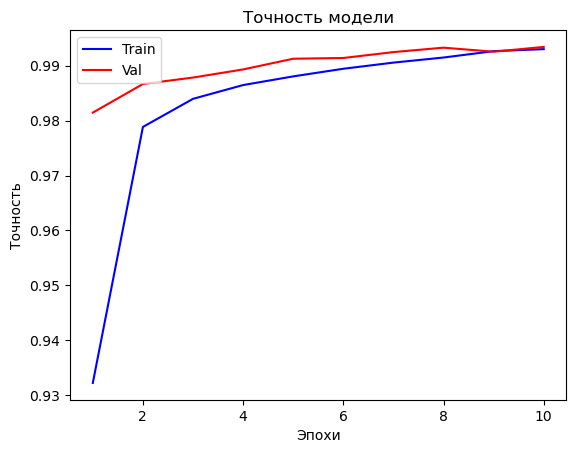

In [88]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, 'b')
plt.plot(epochs, val_acc, 'r')
plt.title('Точность модели')
plt.ylabel('Точность')
plt.xlabel('Эпохи')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

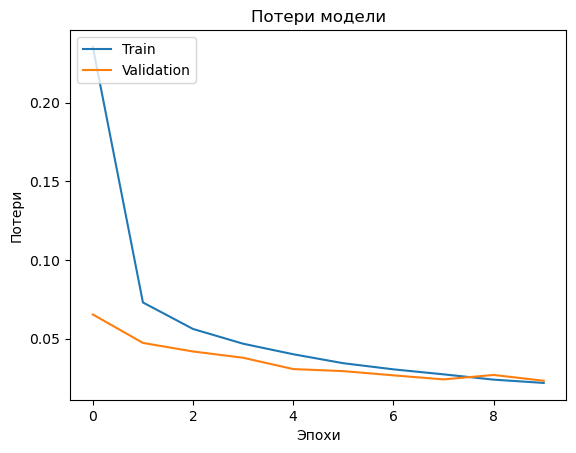

In [90]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Потери модели')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [92]:
_, train_accuracy = model.evaluate(X_t, y_t, verbose=0)
print(f'Точность на тренировочном наборе {train_accuracy * 100:.2f}%')

Точность на тренировочном наборе 99.72%


In [93]:
_, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Точность на проверочных данных: {val_accuracy * 100:.2f}%")

Validation Accuracy: 99.34%


In [94]:
_, test_accuracy = model.evaluate(test_images, y_test_classes, verbose=0)
print(f"Точность на тестовых данных: {test_accuracy * 100:.2f}%")

Точность на тестовых данных: 99.34%


Загружаем нашу обученную модель(веса).

In [95]:
model_path = 'model_cnn.keras'
loaded_model = load_model(model_path)

Посмотрим как предсказывает модель

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


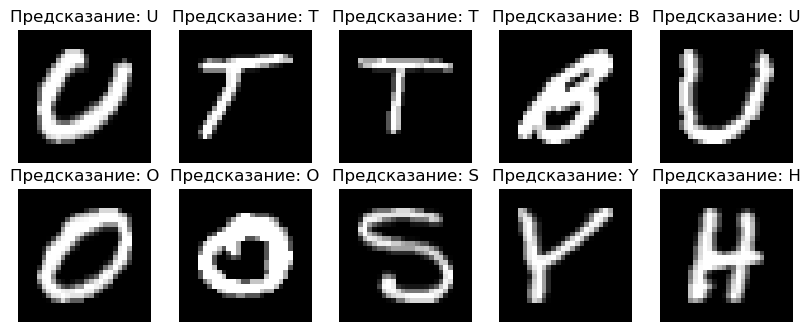

In [99]:
selected_images = X_val[1900:1910]
predictions = loaded_model.predict(selected_images)

plt.figure(figsize=(10, 10))
for i, (image, prediction) in enumerate(zip(selected_images, predictions), start=1):
    # Get the predicted label
    predicted_label = word_dict[np.argmax(prediction)]

    # Plot the image
    plt.subplot(5, 5, i)
    plt.imshow(image[:, :, 0], cmap='gray')  # Assuming images are grayscale
    plt.title(f'Предсказание: {predicted_label}')
    plt.axis('off')

plt.show()